# Qualitative experiment with FRWI and LIME
### on WiSARD, Ridge Regression and Random Forest
### trainned with MNIST

#### loading dataset
MNIST

training data:

X 60000:784

y 60000:1

testing data:

X 10000:784

y 10000:1

In [2]:
%%time
import sys
sys.path.insert(1, './datasets')
import numpy as np

from mnist.loader import load_data
X,y, X_test, y_test = load_data('./datasets/mnist/')
# X = np.array(X,dtype=np.float32)
y = np.array(y,dtype=np.float32)
# X_test = np.array(X_test,dtype=np.float32)
y_test = np.array(y_test,dtype=np.float32)

CPU times: user 320 ms, sys: 61.5 ms, total: 382 ms
Wall time: 381 ms


indeces of unique classes [0, 1, 2, 3, 4, 7, 8, 11, 18, 61]


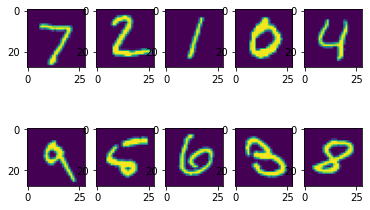

In [3]:
import matplotlib.pyplot as plt
classes = []
indices = []
for i,v in enumerate(y_test):
    if v not in classes:
        classes.append(v)
        indices.append(i)
        if len(indices) == 10:
            break
print("indeces of unique classes",indices)

_, ax = plt.subplots(2,5)
for i in range(10):
    img = X_test[indices[i]]
    ax[i//5][i%5].imshow(img)

### Testing on WiSARD

#### training model and testing

In [5]:
%%time
import sklearn.metrics as metrics
import wisardpkg as wp
bin = wp.MeanThreshold(4)
wsd = wp.Wisard(784,40,binarizer=bin)

wsd.train(X,y)

y_pred = wsd.classify(X_test)
acc = metrics.accuracy_score(y_pred,y_test)

print("accuracy:",acc)

accuracy: 0.9585
CPU times: user 4.34 s, sys: 93.9 ms, total: 4.44 s
Wall time: 4.45 s


#### interpreting with FRWI

In [4]:
%%time
from xaiwann import FRWI
from tqdm import tqdm
from PIL import Image

window = 4
frwi = FRWI(window,28,28)
samples = 10000
greyValue = 0

lmis = []
for i in tqdm(range(10)):
    img = np.array(X_test[indices[i]],np.uint8)
    data = frwi.generatePermutations(img, greyValue, samples)

    c = wsd.predict(np.array([img]))
    responses = wsd.predict(data)

    lmi = frwi.explain(responses,c)
    lmis.append(lmi)

100%|██████████| 10/10 [01:14<00:00,  7.43s/it]

CPU times: user 1min 13s, sys: 221 ms, total: 1min 14s
Wall time: 1min 14s


100%|██████████| 10/10 [00:00<00:00, 637.39it/s]


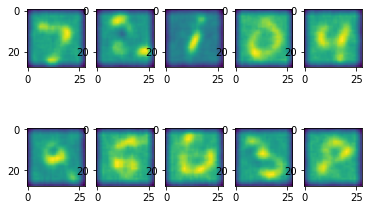

In [5]:
fig, ax = plt.subplots(2,5)
for i in tqdm(range(10)):
    positive = np.reshape(lmis[i][:784],(28,28))
    ax[i//5][i%5].imshow(positive)

#### interpreting with LIME

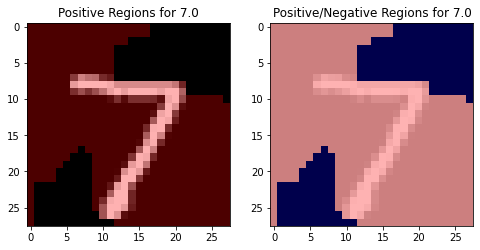

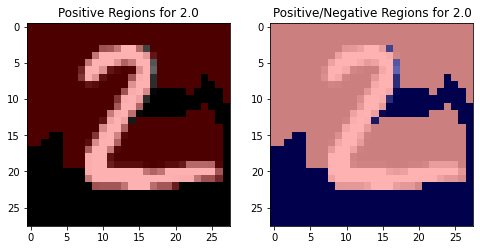

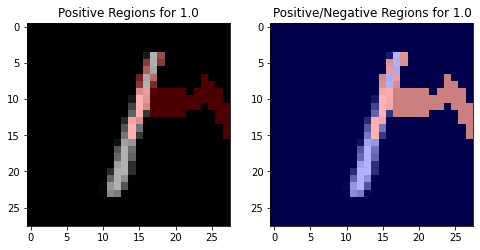

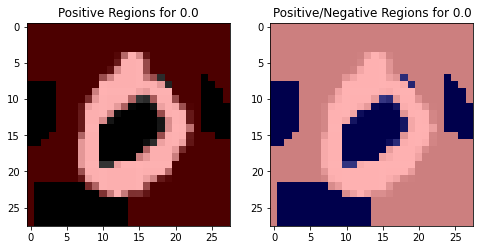

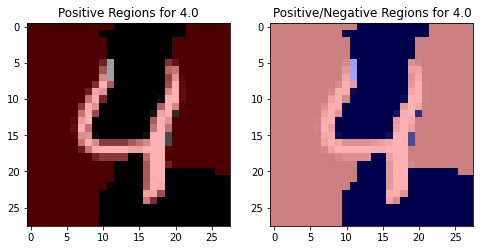

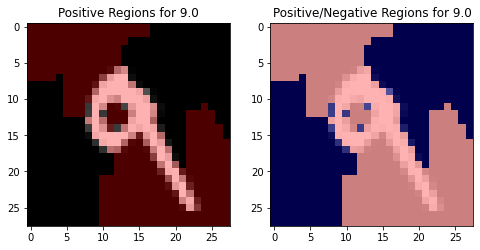

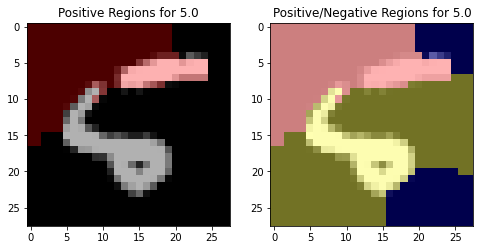

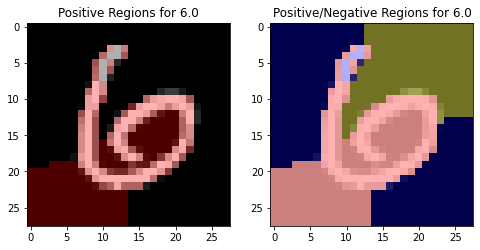

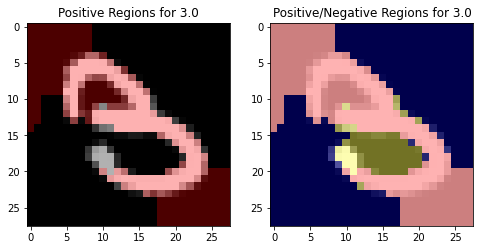

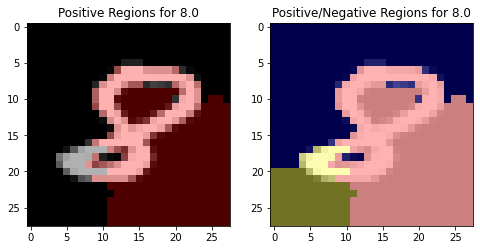

In [4]:
from lime import lime_image
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
from lime.wrappers.scikit_image import SegmentationAlgorithm


explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

def classifier_wsd(data):
    dd = np.array(np.stack([ rgb2gray(d) for d in data],0)*255,dtype=np.uint8).reshape((-1,784))
    return wsd.predict(dd)

for i in indices:
    img_raw = gray2rgb(X_test[i])
    explanation = explainer.explain_instance(img_raw, 
        classifier_fn = classifier_wsd, segmentation_fn=segmenter,
        top_labels=10, hide_color=0, num_samples=10000, batch_size=1000)
    
    temp, mask = explanation.get_image_and_mask(y_test[i], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax1.set_title('Positive Regions for {}'.format(y_test[i]))
    
    temp, mask = explanation.get_image_and_mask(y_test[i], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
    ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax2.set_title('Positive/Negative Regions for {}'.format(y_test[i]))
    
    


### Testing on Ridge Regression

#### training model and testing

In [22]:
%%time
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
import sklearn.metrics as metrics

yp = OneHotEncoder()
y2 = y.reshape(60000,1)
y_temp = yp.fit_transform(y2).toarray()
linear = linear_model.Ridge(alpha = 0)
linear.fit(X.reshape(60000,784),y_temp)

y_pred = np.argmax(linear.predict(X_test.reshape(10000,784)),axis=1)
acc = metrics.accuracy_score(y_pred,y_test.reshape(10000,1))

print("Accuracy:", acc)

Accuracy: 0.8477
CPU times: user 49.5 s, sys: 18 s, total: 1min 7s
Wall time: 27.7 s


#### interpreting with FRWI

In [23]:
%%time
from xaiwann import FRWI
from tqdm import tqdm
from PIL import Image

window = 4
frwi = FRWI(window,28,28)
samples = 10000
greyValue = 0

lmis = []
for i in tqdm(range(10)):
    img = np.array(X_test[indices[i]],np.uint8)
    data = frwi.generatePermutations(img, greyValue, samples)

    c = np.array(linear.predict(np.array([img]).reshape(1,784)),dtype=np.float32)
    responses = np.array(linear.predict(data.reshape(samples,784)),dtype=np.float32)

    lmi = frwi.explain(responses,c)
    lmis.append(lmi)

100%|██████████| 10/10 [01:08<00:00,  6.88s/it]

CPU times: user 1min 8s, sys: 1.81 s, total: 1min 9s
Wall time: 1min 8s


100%|██████████| 10/10 [00:00<00:00, 595.00it/s]


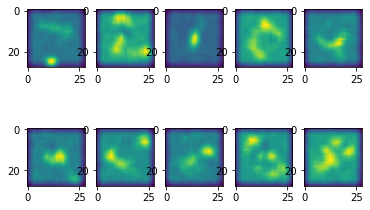

In [24]:
fig, ax = plt.subplots(2,5)
for i in tqdm(range(10)):
    positive = np.reshape(lmis[i][:784],(28,28))
    ax[i//5][i%5].imshow(positive)

#### interpreting with LIME

In [5]:
from lime import lime_image
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
from lime.wrappers.scikit_image import SegmentationAlgorithm


explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

def classifier_linear(data):
    dd = np.array(np.stack([ rgb2gray(d) for d in data],0)*255,dtype=np.uint8).reshape((-1,784))
    return linear.predict(dd)

for i in indices:
    img_raw = gray2rgb(X_test[i])
    explanation = explainer.explain_instance(img_raw,
        classifier_fn = classifier_linear, segmentation_fn=segmenter,
        top_labels=10, hide_color=0, num_samples=10000, batch_size=1000)
    
    temp, mask = explanation.get_image_and_mask(y_test[i], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax1.set_title('Positive Regions for {}'.format(y_test[i]))
    
    temp, mask = explanation.get_image_and_mask(y_test[i], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
    ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax2.set_title('Positive/Negative Regions for {}'.format(y_test[i]))
    
    


TypeError: explain_instance() got an unexpected keyword argument 'verbose'

### Testing on Random Forest

#### training model and testing

In [26]:
%%time
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

random_forest = Pipeline([
    ('Normalize', Normalizer()),
    ('RF', RandomForestClassifier())
                            ])
random_forest.fit(X.reshape(60000,784),y)


probas = random_forest.predict_proba(X_test.reshape(10000,784))
y_pred = np.argmax(probas,axis=1)
acc = metrics.accuracy_score(y_pred,y_test)
print("Accuracy:", acc)

Accuracy: 0.969
CPU times: user 1min 41s, sys: 356 ms, total: 1min 42s
Wall time: 1min 42s


#### interpreting with FRWI

In [27]:
%%time
from xaiwann import FRWI
from tqdm import tqdm
from PIL import Image

window = 4
frwi = FRWI(window,28,28)
samples = 10000
greyValue = 0

lmis = []
for i in tqdm(range(10)):
    img = np.array(X_test[indices[i]],np.uint8)
    data = frwi.generatePermutations(img, greyValue, samples)

    
    c = np.array(random_forest.predict_proba(np.array([img]).reshape(1,784)),dtype=np.float32)
    responses = np.array(random_forest.predict_proba(data.reshape(samples,784)),dtype=np.float32)

    lmi = frwi.explain(responses,c)
    lmis.append(lmi)

100%|██████████| 10/10 [01:17<00:00,  7.76s/it]

CPU times: user 1min 17s, sys: 231 ms, total: 1min 17s
Wall time: 1min 17s


100%|██████████| 10/10 [00:00<00:00, 656.72it/s]


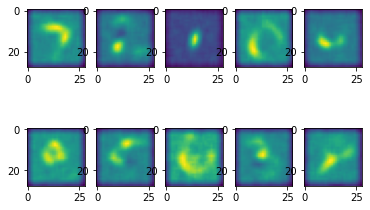

In [28]:
fig, ax = plt.subplots(2,5)
for i in tqdm(range(10)):
    positive = np.reshape(lmis[i][:784],(28,28))
    ax[i//5][i%5].imshow(positive)

#### interpreting with LIME


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]



[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]



[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]



[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]



[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]



[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]



[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]



[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]



[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]



[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


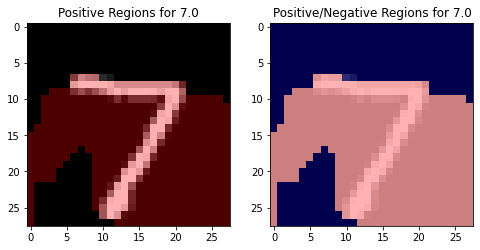

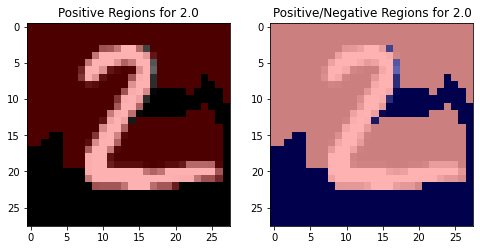

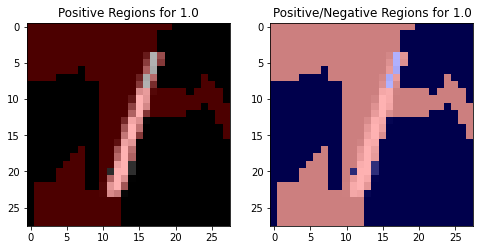

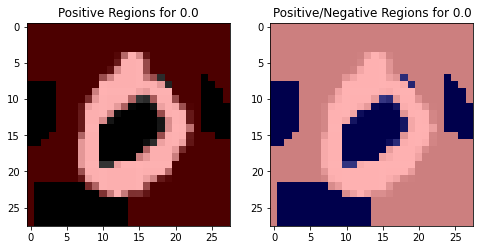

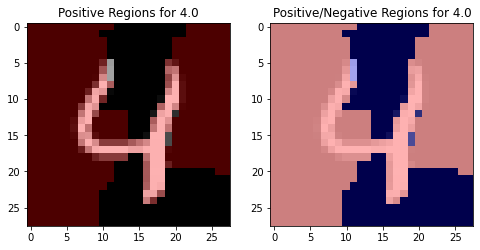

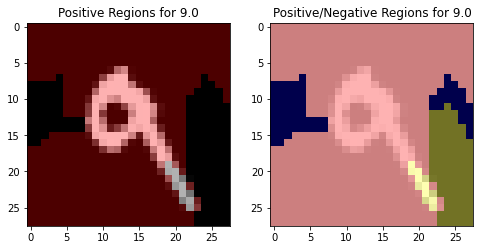

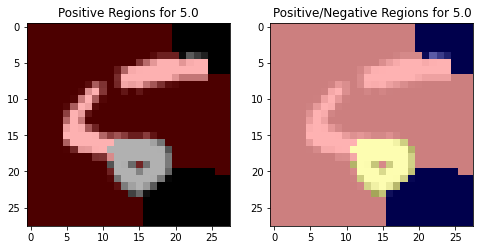

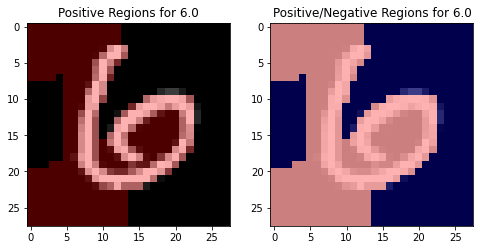

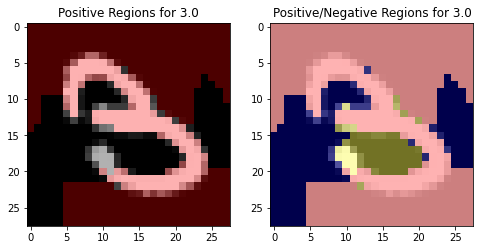

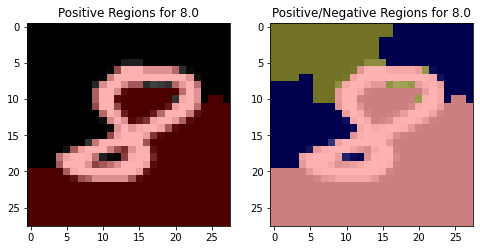

In [33]:
from lime import lime_image
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
from lime.wrappers.scikit_image import SegmentationAlgorithm


explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

def classifier_random_forest(data):
    dd = np.array(np.stack([ rgb2gray(d) for d in data],0)*255,dtype=np.uint8).reshape((-1,784))
    return random_forest.predict_proba(dd)

for i in indices:
    img_raw = gray2rgb(X_test[i])
    explanation = explainer.explain_instance(img_raw, 
        classifier_fn = classifier_random_forest, segmentation_fn=segmenter,
        top_labels=10, hide_color=0, num_samples=10000, batch_size=1000)
    
    temp, mask = explanation.get_image_and_mask(y_test[i], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax1.set_title('Positive Regions for {}'.format(y_test[i]))
    
    temp, mask = explanation.get_image_and_mask(y_test[i], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
    ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax2.set_title('Positive/Negative Regions for {}'.format(y_test[i]))
    
    
